In [4]:
# Prepare graph data...
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import namedtuple
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])
class GraphDataset():
    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)
def get_dataset(input_dir,n_files):
    return GraphDataset(input_dir, n_files)
def load_graph(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)
#Function to load X, Ri, Ro, Y.
def load_raw(graph_name,xyr):
    graph_ex=load_graph(graph_name)
    #Load raw data
    y=graph_ex.y
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    X=graph_ex.X
    if xyr=='X':
        return X
    elif xyr=='Ri':
        return Ri
    elif xyr=='Ro':
        return Ro
    else:
        return y

In [5]:
# Load X data of dimension Nv x 4(including color)
import os
import pandas as pd
dir_ = os.path.join(os.getcwd(), 'color')
#dir_ = os.path.join(os.getcwd(), 'coloredX')
file_path = os.path.join(dir_, "event000001000_g000.csv")
v = pd.read_csv(file_path)
print("features data loaded...")

features data loaded...


In [6]:
#Convenient representation of edge data 
#edges = [[i1,j1], [i2,j2], ... ]; i1, i2,... are outgoing-nodes, and j1, j2, ... are incoming-nodes
import json
graph='event000001000_g000'
with open("./networks/"+graph+".json", "r") as json_file:
        _,_,edges= json.load(json_file)
print("edge data loaded...")

edge data loaded...


In [36]:
#Reduced adjacency matrix A
cut=6
#A[i][j]==1 implies there is an edge between i, j-th nodes.
A=[[0 for _ in range(cut)] for _ in range(cut)]
#Collect edges with its end in the "cut" bound
red_edges=[]
for s,e in edges:
    if s<cut and e<cut:
        red_edges.append([s,e])
for s,e in red_edges:
    A[s][e]=1
print("Adjacency matrix prepared...")

Adjacency matrix prepared...


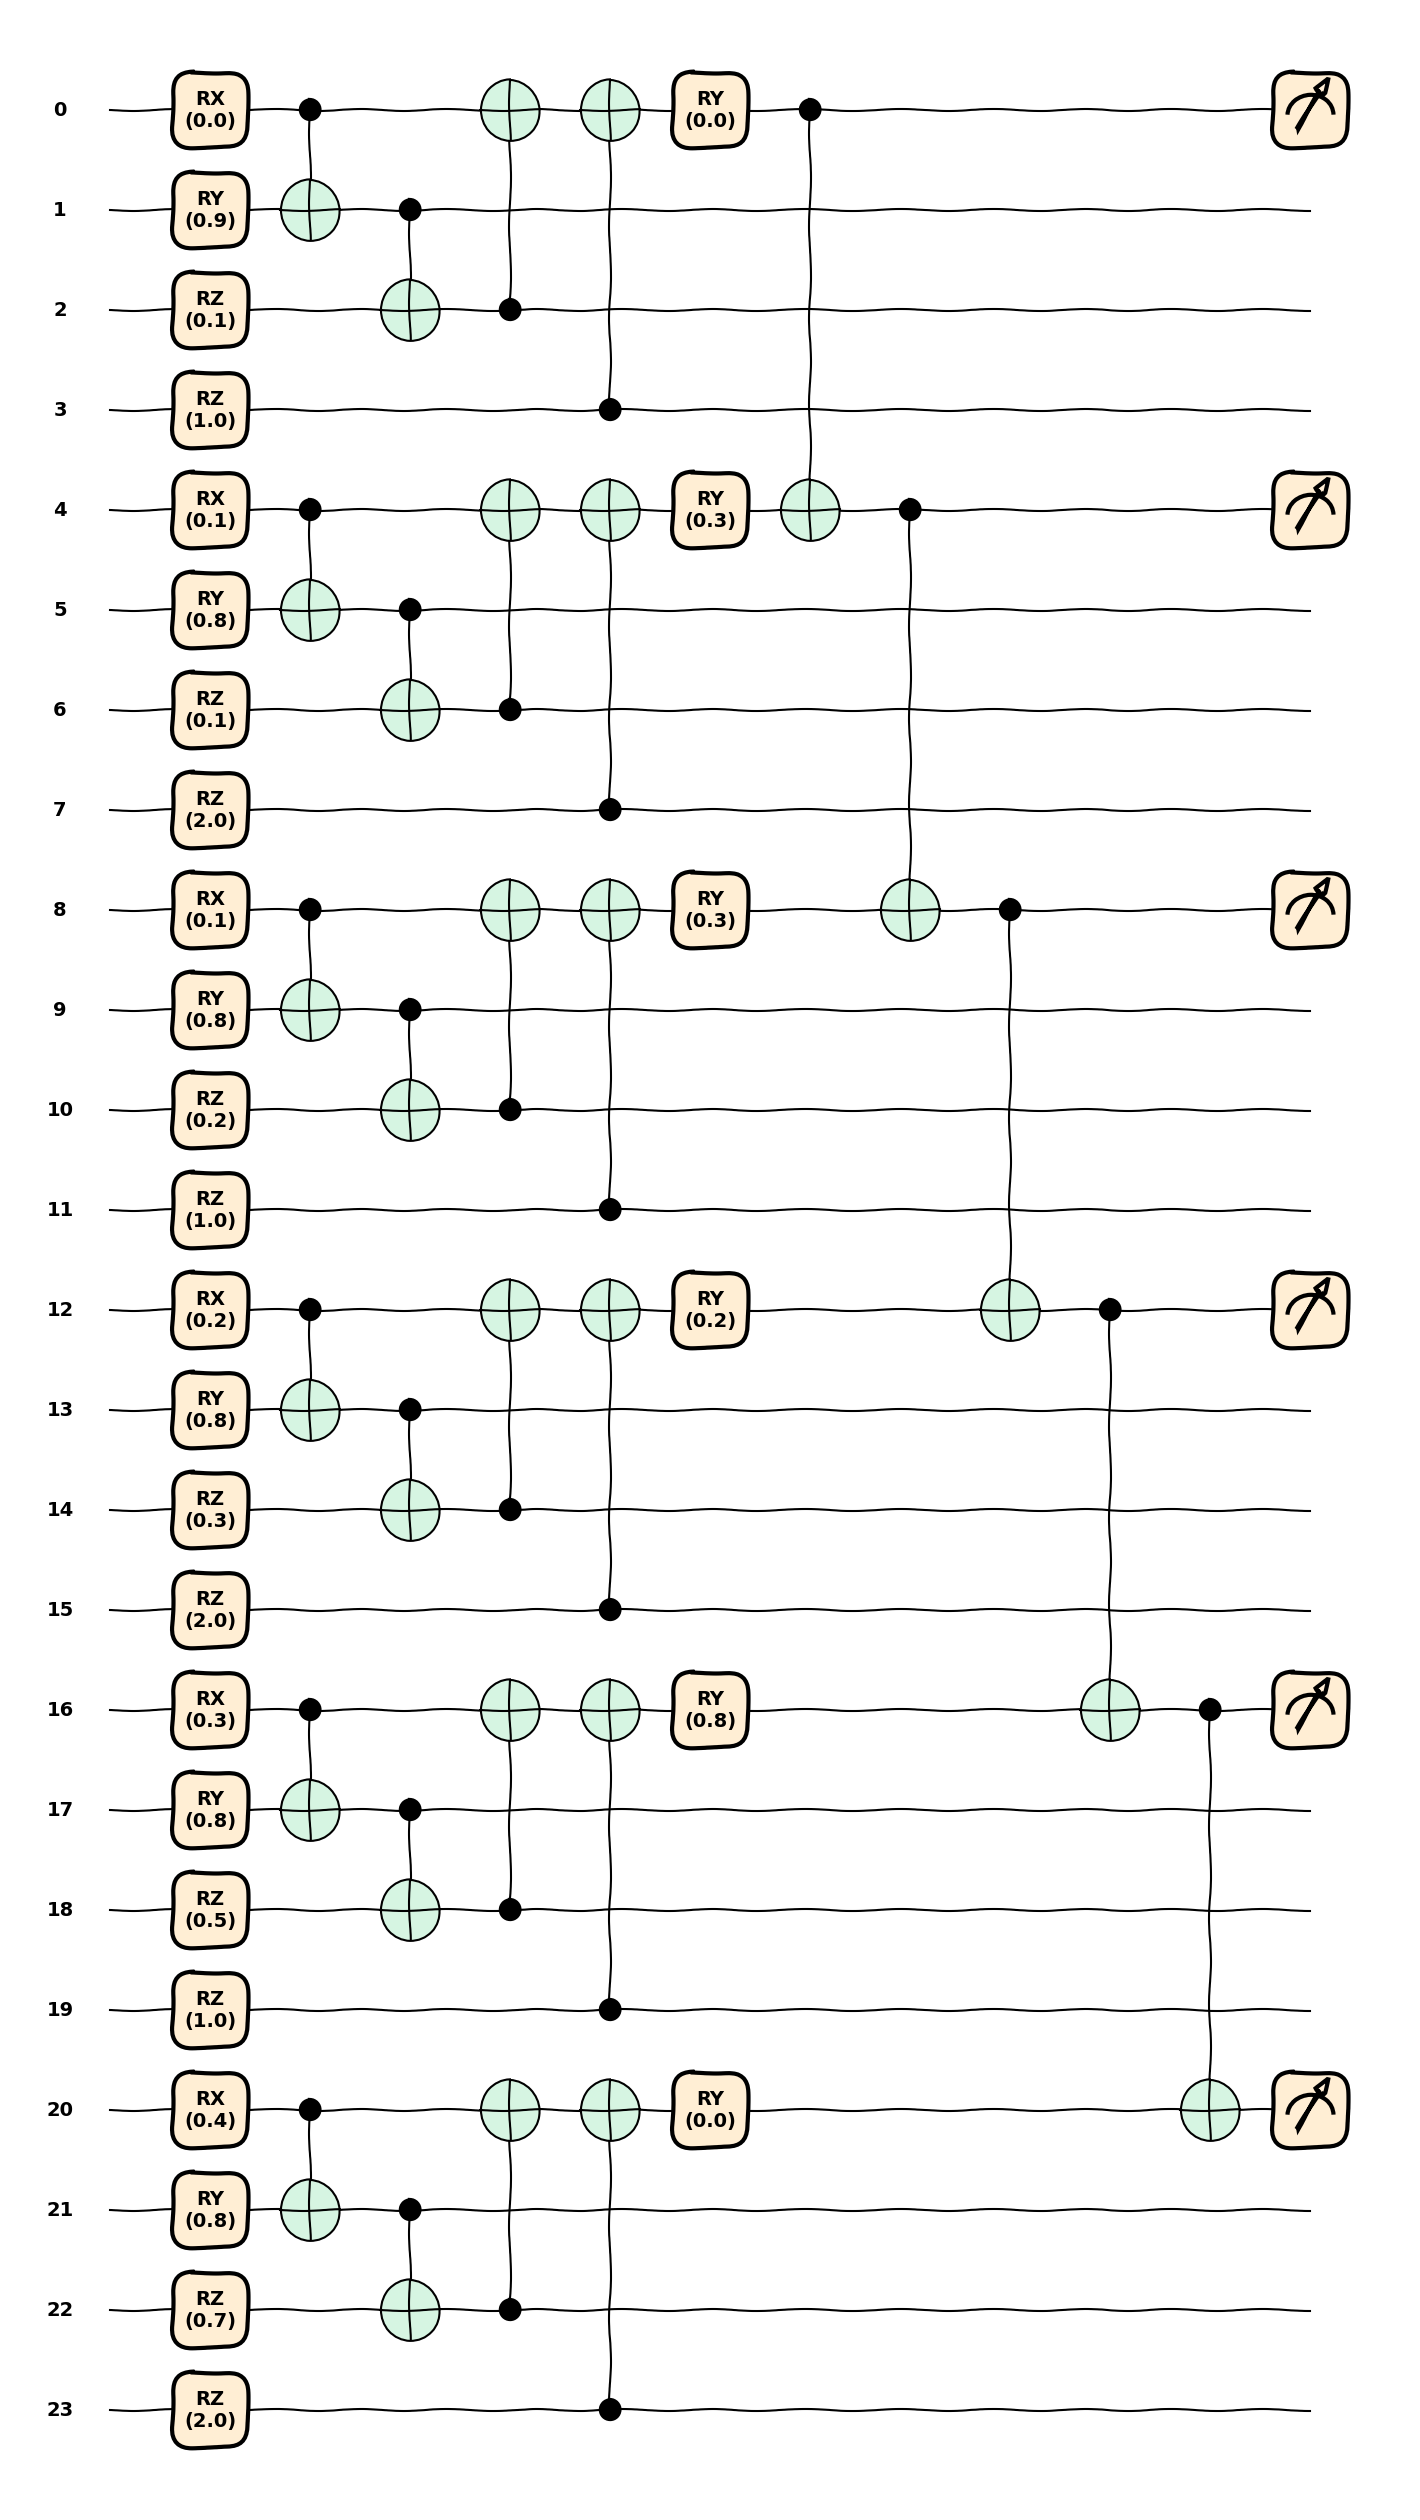

In [41]:
import pennylane as qml

from qiskit.circuit import Parameter
# Reduced colored X data
raw_data=v[:cut].values
X=raw_data.flatten()
# Create a quantum circuit with Nv qubits
Nv = len(raw_data)
num_qubits = Nv * 4  # 4 qubits per row (x,y,z,color)
# Initialize a quantum circuit
def circuit(X, ansatz):
    dev = qml.device('default.qubit', wires=Nv*4)
    @qml.qnode(dev)
    def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(4):
                if j==0:
                    qml.RX(X[i*4+j], wires = i * 4 + j)
                elif j==1:
                    qml.RY(X[i*4+j], wires = i * 4 + j)
                else:
                    qml.RZ(X[i*4+j], wires = i * 4 + j)
        #Entangle 3 positions
        qml.CNOT(wires = [i * 4, i * 4 + 1])
        qml.CNOT(wires = [i * 4 + 1, i * 4 + 2])
        qml.CNOT(wires = [i * 4 + 2, i * 4])
        #Entangle color and position-x.
        qml.CNOT(wires = [i * 4 + 3, i * 4])
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * 4)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * 4, j * 4])
        return [qml.expval(qml.PauliZ(i*4)) for i in range(Nv)]
    expectations = quantum_circuit(X, ansatz)
    return expectations
    #feature = np.random.random(size=(cut*4))
angles = np.random.random(size=(cut*4))
#for i in range(num_qubits):
#    angles.append(Parameter('phi_{}'.format(i)))
# Define a list of trainable parameters for the entanglement
num_params = len(A)  # Number of trainable parameters for the entanglement
ansatz = np.random.random(size=(num_params))
#for i in range(num_params):
#    ansatz.append(Parameter('theta_{}'.format(i)))
def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(4):
                if j==0:
                    qml.RX(X[i*4+j], wires = i * 4 + j)
                elif j==1:
                    qml.RY(X[i*4+j], wires = i * 4 + j)
                else:
                    qml.RZ(X[i*4+j], wires = i * 4 + j)
            #Entangle 3 positions
            qml.CNOT(wires = [i * 4, i * 4 + 1])
            qml.CNOT(wires = [i * 4 + 1, i * 4 + 2])
            qml.CNOT(wires = [i * 4 + 2, i * 4])
            #Entangle color and position-x.
            qml.CNOT(wires = [i * 4 + 3, i * 4])
            # Encode each feature value into a qubit 
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * 4)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * 4, j * 4])
        return [qml.expval(qml.PauliZ(i*4)) for i in range(Nv)]

dev = qml.device("default.qubit", wires=4*Nv)
qnode = qml.QNode(quantum_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(X,ansatz)
plt.show()

In [38]:
# Add measurement operations based on adjacency matrix A
look = [0 for _ in range(len(A))]
for i in range(len(A)):
    for j in range(i + 1, len(A)):
        if A[i][j] == 1:
            look[j]=1
#Edge info is collected in look
#Would like to compare it with QNN output
print("Compare Y with the following positions..")
print(look)

Compare Y with the following positions..
[0, 1, 1, 1, 1, 1]


In [39]:
# Prepare data for training (quantum circuits and labels)
y = load_raw('event000001000_g000.npz','y')
# For now, only look at first "cut" edges.
Y = np.array(y[:cut])  # True edge labels of dimension
epsilon=0.01
#Need to regularize Y to prevent Log(0) in loss function
for i in range(len(Y)):
    if Y[i]==0:
        Y[i]+=epsilon
    else:
        Y[i]-=epsilon
#Binary entropy loss function
def binary(x,xp):
    res=[x[i]*np.log(1-xp[i])+(1-x[i])*np.log(xp[i])
        for i in range(len(x))]
    return -(1/len(x))*sum(res)
def costfunc(params):
    cost = binary(circuit(X, params),Y[:Nv])
    return cost
from pennylane import numpy as np
#Initialize trainable parameters
ansatz = np.random.normal(0, 0.01, size=(num_params), requires_grad=True)
#Set-up the optimizer
optimizer = qml.AdamOptimizer(stepsize=0.01)
previous_cost = float('inf')  # Set to a large initial value
# A small threshold to check for convergence
tolerance = 1e-4  
#Training start
for k in range(30):
    cost=costfunc(ansatz)
    if k % 3 == 0:
        print(f"Step {k}, cost: {cost}")
    if abs(cost - previous_cost) < tolerance:
        print(f"Converged at step {k}, cost: {cost}")
        break
    ansatz = optimizer.step(costfunc, ansatz)
    previous_cost=cost

Step 0, cost: 1.1231530807241232
Step 3, cost: 1.121658638607957
Converged at step 3, cost: 1.121658638607957


In [40]:
#Measure with the fixed parameters
dev = qml.device('default.qubit', wires=Nv*4)
@qml.qnode(dev)
def measure(X,ansatz):
    expect = quantum_circuit(X,ansatz)
    return expect
result=measure(X,ansatz)
def zeroOne(arr):
    return [1 if n>0.5 else 0 for n in arr]
print("Compare the result ",zeroOne(result)," with ",y[:cut])

All 4 features encoded in QC...
All 4 features encoded in QC...
All 4 features encoded in QC...
All 4 features encoded in QC...
All 4 features encoded in QC...
All 4 features encoded in QC...
Entangling qubits using fake adjacency matrix...
Parameterized quantum circuit ready...
Compare the result  [1, 0, 0, 0, 0, 0]  with  [1. 0. 0. 0. 0. 0.]
